In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from layers import AUGRU
from activations import Dice,dice
import pandas as pd
from model import DIEN
import exp_data_reader as data_reader
import utils
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.pyplot import MultipleLocator
import numpy as np
import os
from loss import AuxLayer

C:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
def mkdir(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
        return 0
    except:
        return 1
model_name = "dien"

In [3]:
def is_in_notebook():
    import sys
    return 'ipykernel' in sys.modules
def clear_output():
    """
    clear output for both jupyter notebook and the console
    """
    import os
    os.system('cls' if os.name == 'nt' else 'clear')
    if is_in_notebook():
        from IPython.display import clear_output as clear
        clear()

In [4]:
print(1)
clear_output()
print(2)

2


In [5]:
print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

2.4.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  False


In [6]:
file_path = "/nfs/project/boweihan_2/DIEN/dien_final/"
file_path = ""

# 模型训练

In [7]:
train_data,valid_data, test_data, embedding_count = data_reader.get_data()

In [8]:
embedding_features_list = data_reader.get_embedding_features_list()
user_behavior_features = data_reader.get_user_behavior_features()
embedding_count_dict = data_reader.get_embedding_count_dict(embedding_features_list, embedding_count)
embedding_dim_dict = data_reader.get_embedding_dim_dict(embedding_features_list)

In [9]:
import time
stamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
mkdir("./train_log/" + model_name)
log_path = "./train_log/"+model_name+"/%s" % stamp
train_summary_writer = tf.summary.create_file_writer(log_path)
tf.summary.trace_on(graph=True, profiler=True)
loss_file_name = utils.get_file_name()
mkdir("./loss/" + model_name + "/")
utils.make_train_loss_dir(loss_file_name, cols=["train_aux_loss","train_target_loss","train_final_loss"], model=model_name)
utils.make_test_loss_dir(loss_file_name, cols=["test_aux_loss","test_target_loss","test_final_loss"], model=model_name)

Instructions for updating:
use `tf.profiler.experimental.start` instead.


In [10]:
min_batch = 0
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss_metric = tf.keras.metrics.Sum()
auc_metric = tf.keras.metrics.AUC()
alpha = 1
epochs = 3
model = DIEN(
    embedding_count_dict, 
    embedding_dim_dict, 
    embedding_features_list, 
    user_behavior_features, 
    activation="dice")
model


In [11]:
batch=2000
click,banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type,  hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch,reshape_len = data_reader.get_batch_data(train_data, min_batch, batch = batch)

In [12]:
user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict = data_reader.get_train_data( banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type,  hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch) 


In [13]:
def train_one_step(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label, optimizer, model, alpha, loss_metric,batch_size):
    with tf.GradientTape() as tape:
        output, logit, aux_loss = model(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list,batch_size)
        target_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit,labels=tf.cast(label, dtype=tf.float32)))
        final_loss = target_loss + alpha * aux_loss
        print("[Train Step] aux_loss=" + str(aux_loss.numpy()) + ", target_loss=" + str(target_loss.numpy()) + ", final_loss=" + str(final_loss.numpy()))
    gradient = tape.gradient(final_loss, model.trainable_variables)
    clip_gradient, _ = tf.clip_by_global_norm(gradient, 5.0)
    optimizer.apply_gradients(zip(clip_gradient, model.trainable_variables))
    loss_metric(final_loss)
    return aux_loss, target_loss, final_loss

In [14]:
train_data,valid_data, test_data, embedding_count = data_reader.get_data()
embedding_features_list = data_reader.get_embedding_features_list()
user_behavior_features = data_reader.get_user_behavior_features()
embedding_count_dict = data_reader.get_embedding_count_dict(embedding_features_list, embedding_count)
embedding_dim_dict = data_reader.get_embedding_dim_dict(embedding_features_list)
    #for features in embedding_count_dict:
        #print('features is', features)
        #print(embedding_count_dict[features])
model = DIEN(embedding_count_dict, embedding_dim_dict, embedding_features_list, user_behavior_features)
min_batch = 0
batch = 1000
print(len(train_data))
click,banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type,  hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch,reshape_len = data_reader.get_batch_data(train_data, min_batch, batch = batch)
user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict = data_reader.get_train_data( banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type,  hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch) 
log_path = "./train_log/"
train_summary_writer = tf.summary.create_file_writer(log_path)
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss_metric = tf.keras.metrics.Sum()
auc_metric = tf.keras.metrics.AUC()
alpha = 1
epochs = 1
for epoch in range(epochs):
    print('epoch now is',epoch,'with',epochs)
    min_batch = 0
    for i in range(int(len(train_data) / batch)//300):
        if i%100==0:
            print(i,len(train_data)//batch)
        label,banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type,  hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch,reshape_len = data_reader.get_batch_data(train_data, min_batch, batch = batch)
        user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict = data_reader.get_train_data( banner_pos,id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type,hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch)
        label=tf.constant(label,dtype=tf.float32)
        train_one_step(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label, optimizer, model, alpha, loss_metric,batch)

734003
epoch now is 0 with 1
0 734
[Train Step] aux_loss=0.71077496, target_loss=0.6889999, final_loss=1.3997748
[Train Step] aux_loss=0.7091101, target_loss=0.6812828, final_loss=1.3903929


In [15]:
def get_test_loss(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label,batch_size):
    output, logit, aux_loss = model(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list,batch_size)
    target_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit,labels=tf.cast(label, dtype=tf.float32)))
    final_loss = target_loss + alpha * aux_loss
    #print("[Test Loss] aux_loss=" + str(aux_loss.numpy()) + ", target_loss=" + str(target_loss.numpy()) + ", final_loss=" + str(final_loss.numpy()))
    return aux_loss.numpy(), target_loss.numpy(), final_loss.numpy()

In [16]:
get_test_loss(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label,batch)

(0.70751715, 0.6744564, 1.3819735)

In [17]:
for var in model.trainable_variables:
    print(var.name)

dien_1/embedding_25/embeddings:0
dien_1/embedding_36/embeddings:0
dien_1/embedding_37/embeddings:0
dien_1/embedding_38/embeddings:0
dien_1/embedding_39/embeddings:0
dien_1/embedding_40/embeddings:0
dien_1/embedding_41/embeddings:0
dien_1/embedding_42/embeddings:0
dien_1/embedding_43/embeddings:0
dien_1/embedding_31/embeddings:0
dien_1/embedding_30/embeddings:0
dien_1/embedding_29/embeddings:0
dien_1/embedding_22/embeddings:0
dien_1/embedding_35/embeddings:0
dien_1/embedding_32/embeddings:0
dien_1/embedding_33/embeddings:0
dien_1/embedding_34/embeddings:0
dien_1/embedding_24/embeddings:0
dien_1/embedding_23/embeddings:0
dien_1/embedding_28/embeddings:0
dien_1/embedding_27/embeddings:0
dien_1/embedding_26/embeddings:0
dien_1/gru_1/gru_cell_1/kernel:0
dien_1/gru_1/gru_cell_1/recurrent_kernel:0
dien_1/gru_1/gru_cell_1/bias:0
batch_normalization_4/gamma:0
batch_normalization_4/beta:0
dense_12/kernel:0
dense_12/bias:0
dense_13/kernel:0
dense_13/bias:0
dense_14/kernel:0
dense_14/bias:0
dien_1

In [18]:
print(test_data)

                   id      hour    C1  banner_pos   site_id site_domain  \
0        1.000017e+19  14103100  1005           0  235ba823    f6ebf28e   
1        1.000018e+19  14103100  1005           0  1fbe01fe    f3845767   
2        1.000055e+19  14103100  1005           0  1fbe01fe    f3845767   
3        1.000109e+19  14103100  1005           0  85f751fd    c4e18dd6   
4        1.000138e+19  14103100  1005           0  85f751fd    c4e18dd6   
...               ...       ...   ...         ...       ...         ...   
4577459  9.998167e+18  14103123  1005           0  93eaba74    7687a86e   
4577460  9.998250e+18  14103123  1005           0  17d1b03f    f3845767   
4577461  9.998802e+16  14103123  1005           0  5b08c53b    7687a86e   
4577462  9.999087e+18  14103123  1005           0  85f751fd    c4e18dd6   
4577463  9.999264e+16  14103123  1005           0  17d1b03f    f3845767   

        site_category    app_id app_domain app_category  ... device_type  \
0            f028772b  

In [19]:
def get_loss_fig(train_loss, test_loss):
    loss_list = ["aux_loss", "final_loss"]
    color_list = ["r", "b"]
    plt.figure()
    cnt = 0
    for k in loss_list:
        loss = train_loss[k]
        step = list(np.arange(len(loss)))
        plt.plot(step,loss,color_list[cnt]+"-",label="train_" + k, linestyle="--")
        cnt += 1
    cnt = 0
    for k in loss_list:
        loss = test_loss[k]
        step = list(np.arange(len(loss)))
        plt.plot(step,loss,color_list[cnt],label="test_" + k)
        cnt += 1
    plt.title("Loss")
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.legend()
    clear_output()
    plt.savefig("./loss/" + model_name + "/loss.png")
    clear_output()
    plt.show()

In [20]:
def record_test_loss(test_loss, test_data, step, batch):
    min_batch=0
    banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type,  hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch = data_reader.get_test_batch(test_data, min_batch, batch)
    user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict = data_reader.get_test_data( banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type,  hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch) 
    aux_loss, target_loss, final_loss = get_test_loss(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label,batch)
    loss_dict = dict()
    loss_dict["aux_loss"] = str(aux_loss)
    loss_dict["target_loss"] = str(target_loss)
    loss_dict["final_loss"] = str(final_loss)
    utils.add_loss(loss_dict, loss_file_name, level="test")
    test_loss["aux_loss"].append(float(aux_loss))
    test_loss["target_loss"].append(float(target_loss))
    test_loss["final_loss"].append(float(final_loss))
    with train_summary_writer.as_default():
        tf.summary.scalar("test_aux_loss epoch: "+str(epoch), aux_loss, step = step)
        tf.summary.scalar("test_target_loss epoch: "+str(epoch), target_loss, step = step)
        tf.summary.scalar("test_final_loss epoch: "+str(epoch), final_loss, step = step)

In [21]:
mkdir("./checkpoint/" + model_name)
checkpoint_path = "./checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

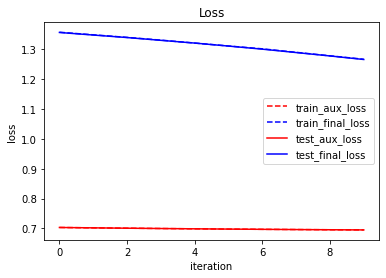

In [25]:
epcohs=3
train_loss = {"aux_loss":[], "target_loss":[], "final_loss":[]}
test_loss = {"aux_loss":[], "target_loss":[], "final_loss":[]}
for epoch in range(epochs):
    for i in range(10):
        record_test_loss(test_loss, valid_data, i ,batch)
        click,banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type,  hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch,reshape_len = data_reader.get_batch_data(train_data, min_batch, batch = batch)        
        user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict = data_reader.get_train_data( banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type,  hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch) 
        aux_loss, target_loss, final_loss =   train_one_step(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label, optimizer, model, alpha, loss_metric,batch)
        #Record_loss12
        loss_dict = dict()
        loss_dict["aux_loss"] = str(aux_loss)
        loss_dict["target_loss"] = str(target_loss)
        loss_dict["final_loss"] = str(final_loss)
        utils.add_loss(loss_dict, loss_file_name, level="train")
        train_loss["aux_loss"].append(float(aux_loss))
        train_loss["target_loss"].append(float(target_loss))
        train_loss["final_loss"].append(float(final_loss))
        get_loss_fig(train_loss, test_loss)
        tf.summary.trace_on(graph=True, profiler=True)
        with train_summary_writer.as_default():
            tf.summary.scalar("train_aux_loss epoch: "+str(epoch), aux_loss, step = i)
            tf.summary.scalar("train_target_loss epoch: "+str(epoch), target_loss, step = i)
            tf.summary.scalar("train_final_loss epoch: "+str(epoch), final_loss, step = i)
            tf.summary.trace_export(
                name="DIEN", 
                step=i, 
                profiler_outdir=log_path)
    model.save_weights(checkpoint_path.format(epoch=epoch))

# 模型评估

In [26]:
last_model = DIEN(embedding_count_dict, embedding_dim_dict, embedding_features_list, user_behavior_features, activation="PReLU")
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
last_model.load_weights(latest)

./checkpoint/dien\cp-0000.ckpt


In [27]:
model= last_model
banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type, hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch= data_reader.get_test_batch(test_data,min_batch,batch)
user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict = data_reader.get_train_data( banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type,  hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch) 
aux_loss, target_loss, final_loss = get_test_loss(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label,batch)
aux_loss, target_loss, final_loss

(0.69459033, 0.56069225, 1.2552826)

In [38]:
def convert_tensor(data):
    return tf.convert_to_tensor(data)
def decode(text):
    Offset=0
    for I in text:
        string = ""
        ASCII = ord(I)
        Result = ASCII + Offset
    return np.array(Result).astype(np.float)
def get_normal_data(data, col):
    if isinstance(data[col].max(),str):
        if int(data[col].max(),16)>1e12:
            return np.array(list(map(decode,data[col].values))).astype(np.float)
        return np.array(list(map(decode,data[col].values))).astype(np.float)
    else:
        res=np.array(list(map(decode,list(map(str,data[col]-data[col].min()+1))))).astype(np.float)
        res=res/res.max()
        return res

def get_sequence_data(data, col):
    rst = []
    max_length = 0
    for i in data[col].values:
        temp = len(list(map(eval,i[1:-1].split(","))))
        if temp > max_length:
            max_length = temp

    for i in data[col].values:
        temp = list(map(eval,i[1:-1].split(",")))
        padding = np.zeros(max_length - len(temp))
        rst.append(list(np.append(np.array(temp), padding)))
    return rst

def get_evaluate_data(data,batch):
    min_batch = 0
    batch_data = data.sample(n=batch)
    id =get_normal_data(batch_data, "id")
    banner_pos = get_normal_data(batch_data, "banner_pos")

    hour =get_normal_data(batch_data, "banner_pos")
    C1=get_normal_data(batch_data, "C1")
    C14=get_normal_data(batch_data, "C14")
    C15=get_normal_data(batch_data, "C15")
    C16=get_normal_data(batch_data, "C16")
    C17=get_normal_data(batch_data, "C17")
    C18=get_normal_data(batch_data, "C18")
    C19=get_normal_data(batch_data, "C19")
    C20=get_normal_data(batch_data, "C20")
    C21=get_normal_data(batch_data, "C21")
    #no_click = get_normal_data(batch_data, "guide_dien_final_train_data.nonclk")
    #label = [click, no_click]
    site_id = get_normal_data(batch_data, "site_id")
    site_domain =  get_normal_data(batch_data, "site_domain")
    site_category = get_normal_data(batch_data, "site_category")
    app_id =  get_normal_data(batch_data, "app_id")
    app_domain = get_normal_data(batch_data, "app_domain")
    app_category = get_normal_data(batch_data, "app_category")
    device_id = get_normal_data(batch_data, "device_id")
    device_model = get_normal_data(batch_data, "device_model")
    device_type = get_normal_data(batch_data, "device_type")
    device_conn_type = get_normal_data(batch_data, "device_conn_type")
    #print('reshape_len is',reshape_len)
    return convert_tensor(banner_pos),convert_tensor(id), convert_tensor(site_id), convert_tensor(site_domain), convert_tensor(site_category), convert_tensor(app_id), convert_tensor(app_domain), convert_tensor(app_category), convert_tensor(device_id), convert_tensor(device_model), convert_tensor(device_type), convert_tensor(device_conn_type),  convert_tensor(hour), convert_tensor(C1), convert_tensor(C14),convert_tensor(C15), convert_tensor(C16),convert_tensor(C17), convert_tensor(C18),convert_tensor(C19), convert_tensor(C20),convert_tensor(C21), min_batch + batch


In [39]:
batch_size=1000
banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type, hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch = get_evaluate_data(test_data,batch)
user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict = data_reader.get_train_data( banner_pos, id,site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_model, device_type, device_conn_type,  hour, C1, C14,C15, C16,C17, C18,C19, C20,C21, min_batch) 
output, logit, aux_loss = model(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list,batch_size)


In [40]:
train_label = train_data["click"].values
positive_num = len(train_label[train_label == 1])
negative_num = len(train_label[train_label == 0])
print("[训练集]正例:负例=%d : %d" % (positive_num, negative_num))
test_label = valid_data["click"].values
positive_num = len(test_label[test_label == 1])
negative_num = len(test_label[test_label == 0])
print("[测试集]正例:负例=%d : %d" % (positive_num, negative_num))

[训练集]正例:负例=117218 : 616785
[测试集]正例:负例=50280 : 264292


In [41]:
y_true = label.numpy()[:,-1]
y_score = output.numpy()[:,-1]

In [42]:
threshold = 0.0031
y_pre = y_score.copy()
y_pre[y_pre > threshold] = 1
y_pre[y_pre <= threshold] = 0

In [43]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
import sklearn.metrics as sm
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt

In [44]:
print(accuracy_score(y_true, y_pre))

0.156


In [45]:
m = sm.confusion_matrix(y_true, y_pre)
print('混淆矩阵为：', m, sep='\n')

混淆矩阵为：
[[  0 844]
 [  0 156]]


In [46]:
r = sm.classification_report(y_true, y_pre)
print('分类报告为：', r, sep='\n')

分类报告为：
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       844
         1.0       0.16      1.00      0.27       156

    accuracy                           0.16      1000
   macro avg       0.08      0.50      0.13      1000
weighted avg       0.02      0.16      0.04      1000



C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_true,y_score)
auc_score

0.5013974966581601

In [48]:
def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

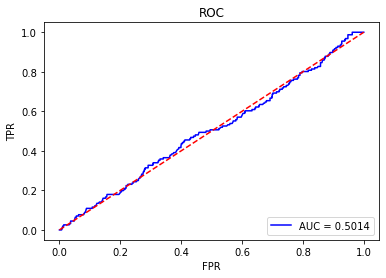

In [49]:
plot_roc(y_true, y_score)

# 整体训练图像

In [51]:
train_loss_data = pd.read_csv("./loss/dien/train_loss.csv.2022_03_23_00_42_04")
train_loss_data

,train_aux_loss,train_target_loss,train_final_loss


In [52]:
test_loss_data = pd.read_csv("./loss/dien/test_loss.csv.2022_03_23_00_42_04")
test_loss_data

,test_aux_loss,test_target_loss,test_final_loss


In [53]:
def get_loss_fig_aux(train_loss_data, test_loss_data):
    train_loss = {
        "aux_loss":list(train_loss_data["train_" + "aux_loss"].values), 
        "target_loss":list(train_loss_data["train_" + "target_loss"].values), 
        "final_loss":list(train_loss_data["train_" + "final_loss"].values)
    }
    test_loss = {
        "aux_loss":list(test_loss_data["test_" + "aux_loss"].values), 
        "target_loss":list(test_loss_data["test_" + "target_loss"].values), 
        "final_loss":list(test_loss_data["test_" + "final_loss"].values)
    }
    get_loss_fig(train_loss, test_loss)

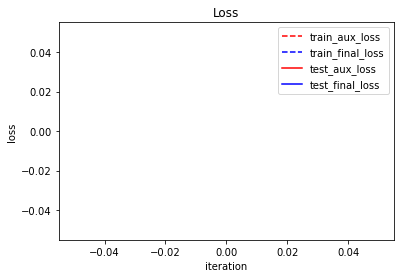

In [54]:
get_loss_fig_aux(train_loss_data, test_loss_data)